# Modeling - Aurora

## Baseline

In [39]:
aurora_arma = ARMA(aurora.diff(2).dropna(), order=(1,0), freq='MS')
res_arma = aurora_arma.fit()

print(f"AIC: {round(res_arma.aic, 2)}")


# This one doesn't work. Throws an error.

# aurora_arma = ARMA(aurora.diff(2).dropna(), order=(2,1), freq='MS')
# res_arma = aurora_arma.fit()

# print(f"AIC: {round(res_arma.aic, 2)}")

# This one doesn't work. Throws an error.

# aurora_arma = ARMA(aurora.diff(2).dropna(), order=(1,1), freq='MS')
# res_arma = aurora_arma.fit()

# print(f"AIC: {round(res_arma.aic, 2)}")

AIC: 4917.31


Baseline is (1,0) with AIC of 4917

## Auto ARIMA

### Train Test Split

Just going with 12 months of test data

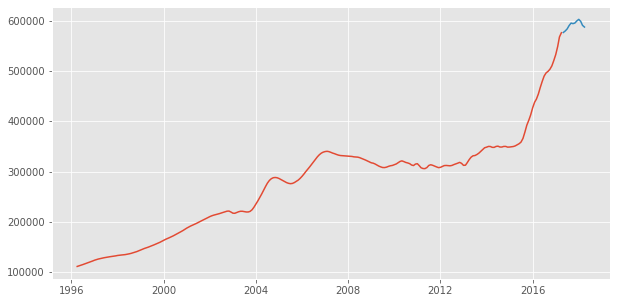

In [40]:
fig = plt.figure(figsize=(10,5))
aurora_train = aurora.iloc[0:253]
aurora_test = aurora.iloc[253:]
plt.plot(aurora_train)
plt.plot(aurora_test)
plt.show()

### Run Auto ARIMA

In [41]:
aurora_auto_arima_train = auto_arima(aurora_train,
                               start_p=0, d=None, start_q=0,
                               max_p=4, max_d=5, max_q=5,
                               suppress_warnings=True, trace=True, stepwise=False, n_fits=20)

 ARIMA(0,2,0)(0,0,0)[1]             : AIC=4396.317, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[1]             : AIC=4400.078, Time=0.05 sec
 ARIMA(0,2,2)(0,0,0)[1]             : AIC=4404.387, Time=0.11 sec
 ARIMA(0,2,3)(0,0,0)[1]             : AIC=4410.157, Time=0.08 sec
 ARIMA(0,2,4)(0,0,0)[1]             : AIC=4406.949, Time=0.14 sec
 ARIMA(0,2,5)(0,0,0)[1]             : AIC=4406.589, Time=0.31 sec
 ARIMA(1,2,0)(0,0,0)[1]             : AIC=4396.947, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[1]             : AIC=4402.564, Time=0.08 sec
 ARIMA(1,2,2)(0,0,0)[1]             : AIC=inf, Time=0.36 sec
 ARIMA(1,2,3)(0,0,0)[1]             : AIC=4399.941, Time=0.53 sec
 ARIMA(1,2,4)(0,0,0)[1]             : AIC=4409.109, Time=0.31 sec
 ARIMA(2,2,0)(0,0,0)[1]             : AIC=4410.880, Time=0.04 sec
 ARIMA(2,2,1)(0,0,0)[1]             : AIC=inf, Time=0.40 sec
 ARIMA(2,2,2)(0,0,0)[1]             : AIC=inf, Time=0.52 sec
 ARIMA(2,2,3)(0,0,0)[1]             : AIC=4409.766, Time=0.67 sec
 ARIMA(3,2,0)(0,0,0)[1]  

#### Check the model

In [42]:
aurora_output = aurora_auto_arima_train.fit(aurora_train)

print(aurora_output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       2.33e+06   8.44e+04     27.614      0.000    2.16e+06     2.5e+06


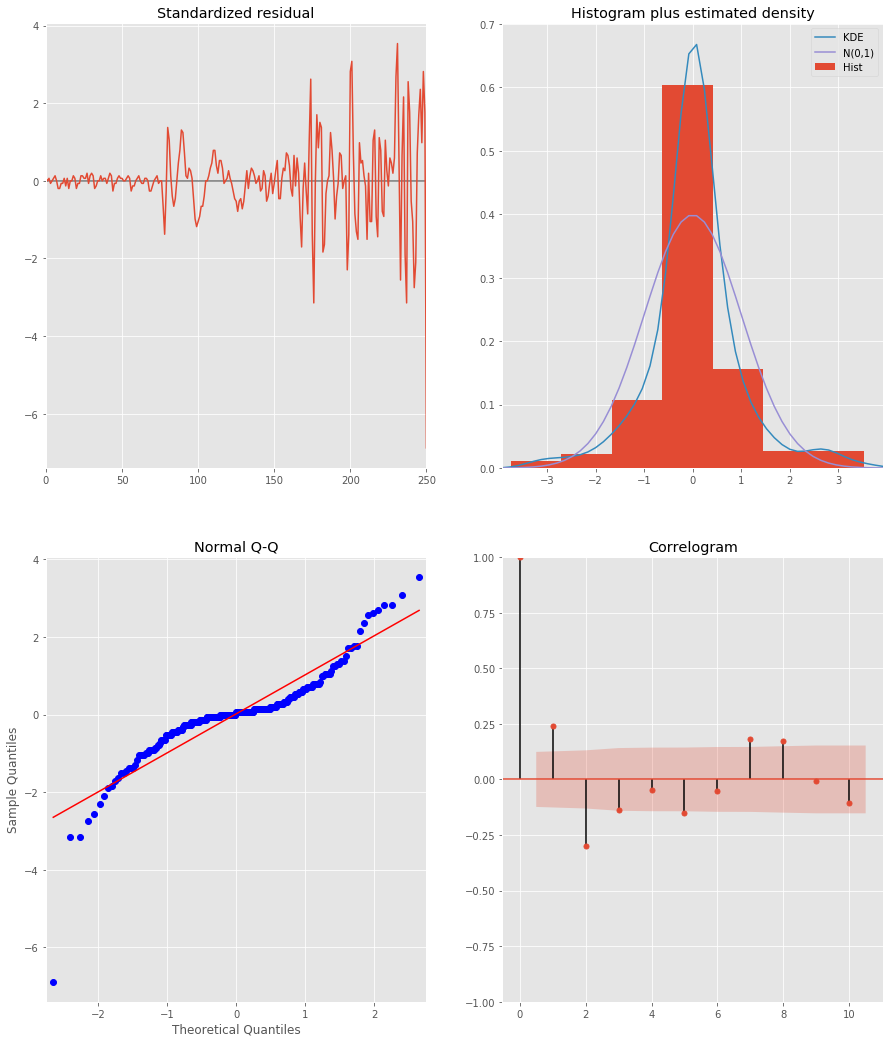

In [43]:
aurora_output.plot_diagnostics(figsize=(15, 18))
plt.show()

#### SARIMAX for increased functionality

C:\Users\halpe\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       2.33e+06   8.44e+04     27.614      0.000    2.16e+06     2.5e+06


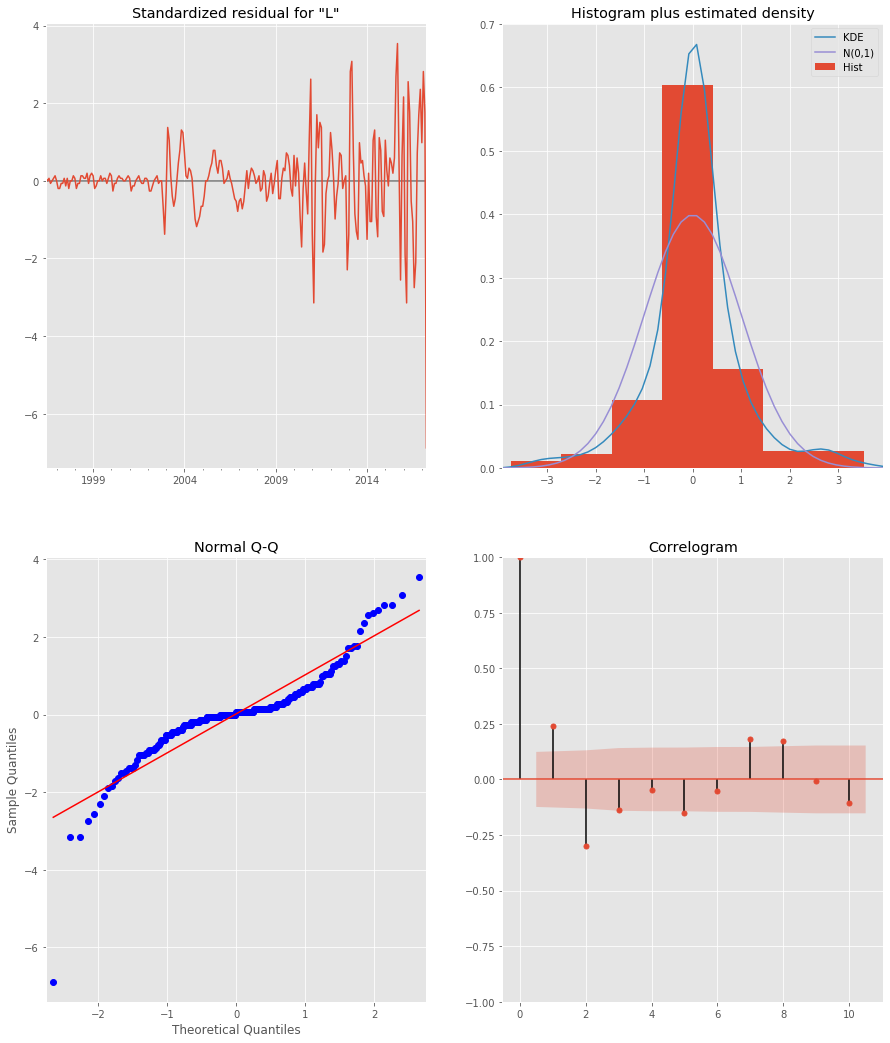

In [44]:
aurora_arima_smx = sm.tsa.statespace.SARIMAX(aurora_train,
                                      order=(0,2,0), 
                                      freq='MS',
                                      enforce_stationarity=True, 
                                      enforce_invertibility=False)
aurora_output = aurora_arima_smx.fit()
print(aurora_output.summary().tables[1])

aurora_output.plot_diagnostics(figsize=(15, 18))
plt.show()

## Validating the model

### Forecasting

In [45]:
pred = aurora_output.get_prediction(start=pd.to_datetime('2016-04-01'), dynamic=False)
pred_conf = pred.conf_int()

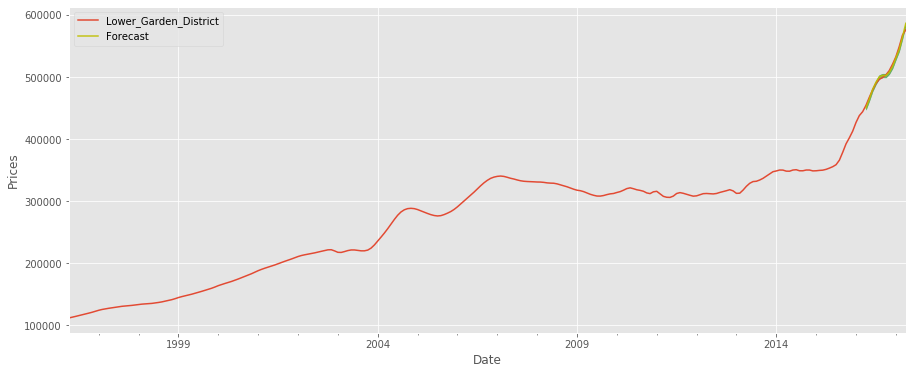

In [46]:
rcParams['figure.figsize'] = 15, 6

# Plot observed values
ax = aurora_train.plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=0.9, color='y')

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Prices')
plt.legend()

plt.show()

The yellow line shows a pretty good fit, but not as good as uptown

In [47]:
# RMSE
aurora_train_forecasted = pred.predicted_mean
aurora_train_truth = aurora_train['2016-04-01':]

rms = mean_squared_error(aurora_train_truth, aurora_train_forecasted, squared=False)
round(rms, 2)

4045.8

### Dynamic Forecasting

In [48]:
aurora_output

In [49]:
pred_dynamic = aurora_output.get_prediction(start=pd.to_datetime('2016-04-01'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

In [50]:
aurora_train_forecasted = pred_dynamic.predicted_mean
aurora_train_truth = aurora_train['2016-04-01':]

rms = mean_squared_error(aurora_train_truth, aurora_train_forecasted, squared=False)
round(rms, 2)

26437.4

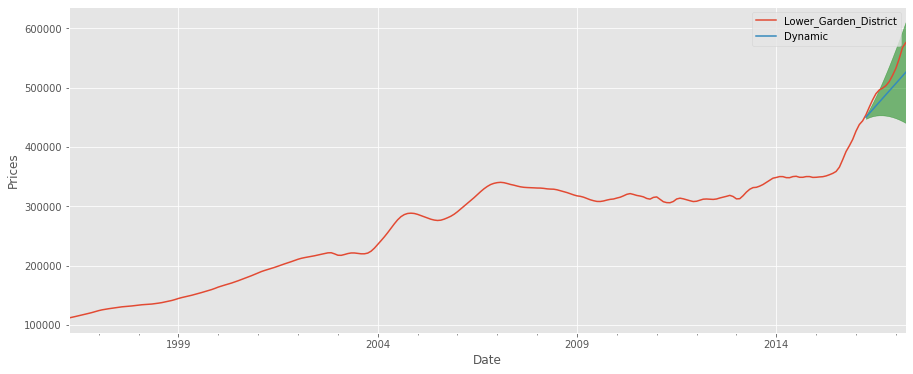

In [51]:
rcParams['figure.figsize'] = 15, 6

# Plot observed values
ax = aurora_train.plot(label='aurora')

# Plot predicted values
pred_dynamic.predicted_mean.plot(ax=ax, label='Dynamic')

# Plot the range for confidence intervals
ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Prices')
plt.legend()

plt.show()

Dynamic forecast seems a little lower than basic forecast

### RMSE

In [52]:
# RMSE on the Forecasted (not dynamic) to compare with test set
forecast = aurora_output.forecast(steps=12)

rms = mean_squared_error(aurora_test, forecast, squared=False)
round(rms, 2)

46788.33

## Producing Forecasts

In [53]:
# Get forecast 24 steps ahead in future
prediction = aurora_output.get_forecast(steps=24)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

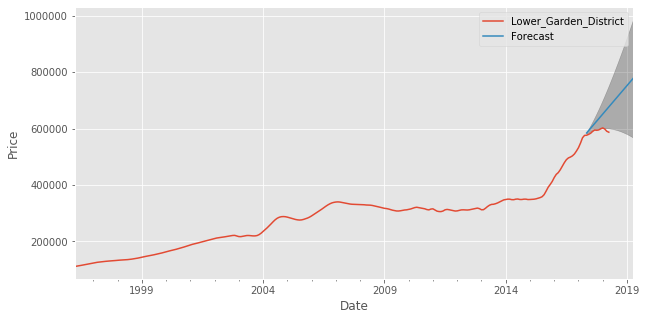

In [54]:
# should I do uptown_train or all of uptown for the plotting?

ax = aurora.plot(label='observed', figsize=(10,5))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('Price')

plt.legend()
plt.show()